In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from util import *
%matplotlib inline

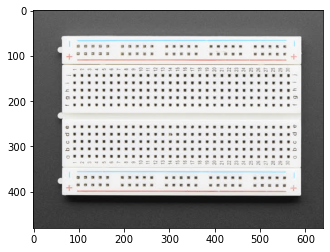

In [165]:
img = cv2.imread('images/breadboard_plain.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display img
plt.imshow(img)
plt.show()


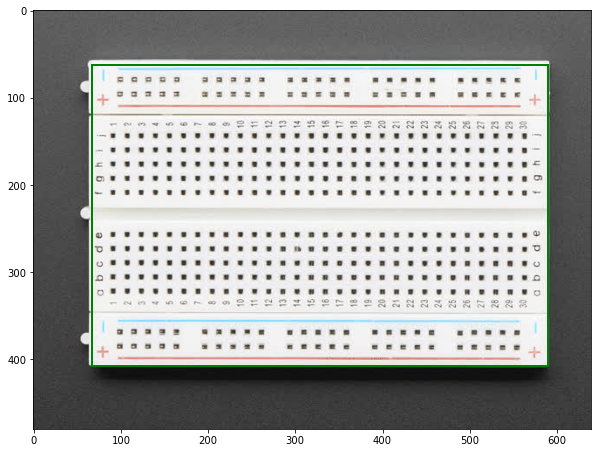

In [166]:
input_boxes = [[67, 62, 590, 407]]
show_boxes_on_image(img, input_boxes)

In [167]:
class Breadboard:
    # i might need to initialize the grid w.r.t with the breadboard coordinates, not image coordinates
    # because in the future, i might combine multiple images
    
    def __init__(self, has_power_rails=True, num_rows=None, num_cols=None, grid=None):
        self.has_power_rails = has_power_rails
        self.num_rows = num_rows # not including power rails
        self.num_cols = num_cols # not including power rails
        self.grid = grid # middle of the breadboard (no power rails)

In [168]:
def identify_breadboard(img, bounding_box):
    num_rows = None
    num_cols = None
    grid = None

    # identify blobs in the image and constrain them to the input boxes
    detector = cv2.SimpleBlobDetector_create()
    keypoints = detector.detect(img)

    # delete keypoints if they are not in the input boxes
    keypoints = [kp for kp in keypoints if kp.pt[0] > input_boxes[0][0] and kp.pt[0] < input_boxes[0][2] and kp.pt[1] > input_boxes[0][1] and kp.pt[1] < input_boxes[0][3]]

    # sort keypoints by y coordinate
    keypoints.sort(key=lambda x: x.pt[1])
    keypoints = [kp.pt for kp in keypoints]
    keypoints = np.array(keypoints, dtype=np.int32)

    # print the total number of keypoints
    show_points_on_image(img, keypoints)
    print("Total number of keypoints: {}".format(len(keypoints)))

    # count unique y coordinates and how many times they appear
    # save as array of tuples (y, count)
    y_counts = np.unique(keypoints[:, 1], return_counts=True)
    y_counts = np.array(y_counts).T

    x_counts = np.unique(keypoints[:, 0], return_counts=True)
    x_counts = np.array(x_counts).T

    # assemble a dictionary, where the key is the y coordinate and the value is a list of x coordinates
    # for example {79: [229, 262, 327, ...]}

    # initialize the dictionary
    y_dict = {}

    # iterate over the y counts
    for y_count in y_counts:
        # get the y coordinate
        y = y_count[0]
        # get the count
        count = y_count[1]
        # get the x coordinates
        x_coords = keypoints[keypoints[:, 1] == y][:, 0]
        # sort the x coordinates
        x_coords.sort()
        # add the y coordinate and the x coordinates to the dictionary
        y_dict[y] = x_coords

    # find the rows with less than half the max keypoints
    max_y_keypoints = np.max(y_counts[:, 1])
    small_y_counts = y_counts[y_counts[:, 1] < max_y_keypoints / 2]

    # for each small y count, find the closest y coordinate with a large y count (check the neighbors from y_dict)
    # find the neighbor with the closest y coordinate, and then append the x coordinates from the small y count to the neighbor
    # delete the small y count from y_dict

    # iterate over the small y counts
    for small_y_count in small_y_counts:
        small_y_coord = small_y_count[0]

        # find the closest y coordinate from y_dict
        # initialize the minimum distance to infinity
        # make sure the closest y coordinate is not the same as the small y coordinate
        min_dist = np.inf
        closest_y_coord = None
        for y_coord in y_dict.keys():
            if y_coord != small_y_coord:
                # calculate the distance between the small y coordinate and the current y coordinate
                dist = abs(small_y_coord - y_coord)
                # if the distance is smaller than the minimum distance, update the minimum distance and the closest y coordinate
                if dist < min_dist:
                    min_dist = dist
                    closest_y_coord = y_coord
        # append the x coordinates from the small y count to the closest y coordinate
        y_dict[closest_y_coord] = np.append(y_dict[closest_y_coord], y_dict[small_y_coord])
        # delete the small y count from y_dict
        del y_dict[small_y_coord]

    # retrieve the updated keypoints from y_dict
    keypoints = []
    for y, x_coords in y_dict.items():
        for x in x_coords:
            keypoints.append([x, y])
    
    show_points_on_image(img, keypoints)
    print("Total number of updated keypoints: {} (should be the same as above)\n".format(len(keypoints)))

    # print the number of keypoints in each row
    for y, x_coords in y_dict.items():
        print("y: {}, number of keypoints: {}".format(y, len(x_coords)))

    return Breadboard(num_rows=num_rows, num_cols=num_cols, grid=grid)

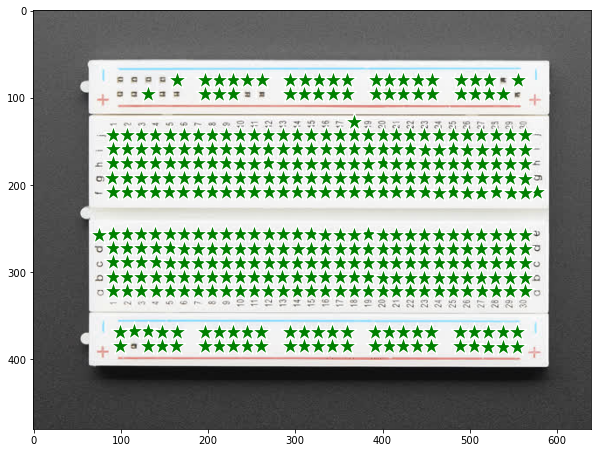

Total number of keypoints: 390


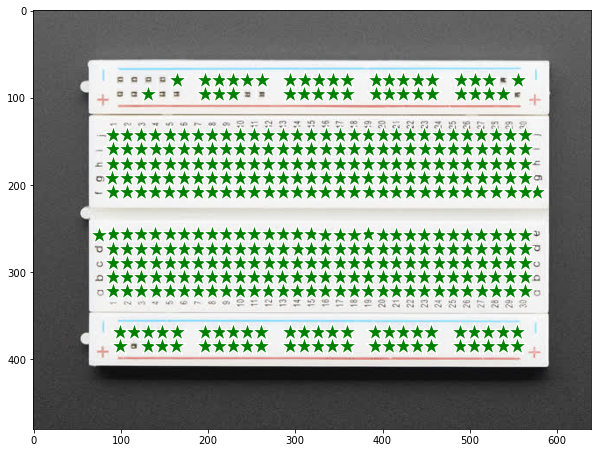

Total number of updated keypoints: 390 (should be the same as above)

y: 79, number of keypoints: 20
y: 96, number of keypoints: 18
y: 143, number of keypoints: 31
y: 159, number of keypoints: 30
y: 176, number of keypoints: 30
y: 192, number of keypoints: 30
y: 208, number of keypoints: 31
y: 256, number of keypoints: 16
y: 257, number of keypoints: 15
y: 273, number of keypoints: 30
y: 289, number of keypoints: 30
y: 305, number of keypoints: 30
y: 322, number of keypoints: 30
y: 368, number of keypoints: 25
y: 385, number of keypoints: 24


In [169]:
bb = identify_breadboard(img, input_boxes[0])